Plots: Campaign 1 Aranzana objects Clustering/Dendrogram

In [1]:
from agn_everest.analysis import *
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, cophenet
from scipy.spatial.distance import pdist

import richardsplot as rplot # for nicer plots
from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel

In [2]:
# EPIC IDs (Investigation ID: GO1035)
GO1035 = pd.read_csv('K2_official_targets/GO1035-targets.csv', skipinitialspace=True)
# 149 objects
# the ones in Figure B1 are all from camapaign 1 
campaign = 1

In [3]:
# functions that may be used (or not)
def split_lc(t, f):
    '''
    Function to split light curves at the discontinuity (halfway point)
    '''
    split = min(t) + (max(t)-min(t))/2
    t1 = t[t<split]
    t2 = t[t>=split]
    f1 = f[t<split]
    f2 = f[t>=split]
    return t1, f1, t2, f2

def detrend(t, f):
    '''
    Function to spilt data, subtract sine curve and return the detrended data, split at the discontinuity
    '''
    # split at the discontinuity
    t1,f1, t2,f2 = split_lc(t, f)
    
    # subract sine fit (de-trending) piecewise
    t1, f1 = subtract_sine(t1, f1)
    t2, f2 = subtract_sine(t2, f2)
    
    return t1,f1, t2,f2 
    

def interp_missing(c, f, gap=None):
    '''
    Function to "interpolate" all the missing cadence points 
    '''
    missing_c = np.setdiff1d(range(min(c), max(c)+1), c)
    
    # incorporate mid campaign gap if necessary
    if gap is not None: missing_c = missing_c[np.logical_not(np.isin(missing_c, gap))]
    
    
    for cm in missing_c:
        # get index right after "missing" time value
        ind = np.argwhere(c > cm)[0]
        # interpolate the "missing" corrected flux values (take the average--linear interp)
        missing_f = (f[ind-1] + f[ind])/2.0
        
        # insert them into the correct locations in the arrays
        f = np.insert(f, ind, missing_f)
        c = np.insert(c, ind, cm)
    
    return c, f


def save_VJ_lightcurve(epic, c):
    """
    Returns MAST server Vanderburg and Johnson light curve path
    """
    if len(str(c)) < 2: c_str = '0'+str(c)
    else: c_str = str(c)

    epic = str(int(epic))
    XXXX = epic[:4]
    YYZZZ = epic[4:]

    url_path = "http://archive.stsci.edu/hlsps/k2sff/c%s/%s00000/%s/hlsp_k2sff_k2_lightcurve_%s-c%s_kepler_v1_llc.fits"%(c_str, XXXX, YYZZZ, epic, c_str)
    
    return url_path


### Download data from MAST
Save to folder ```./k2sff/Aranzana_objects/``` (may need to make this folder)

In [4]:
%%time
# arrays to save time and flux
arr = []
arr_smooth=[]


# for campaign 1
full_cad = np.arange(3919+1)+91434
# remove mid campaign gap
mid_gap = range(93280+1, 93421) # mid campaign gap
full_cad = full_cad[~np.isin(full_cad, mid_gap)]

channel_nums = []
# replicate Aranzana correction for each object below
folder = "k2sff/Aranzana_objects/"

for epic in GO1035['EPIC ID']:

    # get vanderburg and johnson corrected
    with fits.open(folder+"hlsp_k2sff_k2_lightcurve_%s-c%s_kepler_v1_llc.fits"%(epic, "01")) as hdu:
        time = hdu['BESTAPER'].data['T']
        cadence = hdu['BESTAPER'].data['CADENCENO']
        flux = hdu['BESTAPER'].data['FCOR']
        channel = hdu['PRIMARY'].header['CHANNEL']

    channel_nums.append(channel)
    # remove outliers
    lc = lk.LightCurve(time=time, flux=flux)
    _, spurious_cadences = lc.flatten().remove_outliers(return_mask=True)
    lc_clean = lc[~spurious_cadences]

    #full_cad = np.arange(np.max(cadence)-np.min(cadence)+1)+np.min(cadence)
    #mid_gap = range(93280+1, 93421) # mid campaign gap
    #full_cad = full_cad[~np.isin(full_cad, mid_gap)]# remove mid campaign gap
    
    # interpolate any missing cadences
    mask_bool = np.isin(full_cad, cadence[~spurious_cadences])
    interp_vals = np.interp(full_cad[~mask_bool], full_cad[mask_bool], lc_clean.flux)

    f = np.zeros_like(full_cad).astype(float) # placeholder flux array
    np.place(f, mask_bool, lc_clean.flux)
    np.place(f, ~mask_bool, interp_vals)

    # subtract sine fit from light curve before and after the mid campaign gap
    t1,f1,t2,f2 = split_lc(np.array(full_cad)/48.0, f)
    time1, flux_sine1 = subtract_sine(t1,f1)
    time2, flux_sine2 = subtract_sine(t2,f2)


    f_new = np.concatenate([flux_sine1, flux_sine2])
    
    arr.append(f_new)

    # smooth
    f_smooth = convolve(f_new, kernel=Box1DKernel(500), boundary="fill", fill_value=np.median(f_new))
    
    arr_smooth.append(f_smooth)

arr = np.array(arr)
arr_smooth= np.array(arr_smooth)

CPU times: user 5.5 s, sys: 41.7 ms, total: 5.54 s
Wall time: 5.72 s


In [5]:
%%time
# calculate maxmum corss correclation

# put all the correlation coefficients in a matrix
corr_all = np.zeros((len(arr), len(arr)))

data  = arr_smooth.copy()# choose which light curves to use
for i, flux_i in enumerate(data):
    
    for j, flux_j in enumerate(data):
        
        # calculate the maximum value of cross correlation
        corr = np.max(norm_xcorr(flux_i, flux_j))
        
        # write to matrix
        corr_all[i,j] = corr

CPU times: user 1min 8s, sys: 37.3 ms, total: 1min 8s
Wall time: 1min 8s


In [6]:
# generate the linkage matrix
Z = linkage(corr_all, method='median') 

# check how well it performed using Cophenetic corr coeff (closer to 1 is better)
coph, coph_dists = cophenet(Z, pdist(corr_all))
print ("Cophenetic Correlation coefficient = %s" %coph)

# set threshold for clustering
threshold = 1.2

# get clusters
clusters = fcluster(Z, threshold, criterion='distance', depth=8)
print ("Found %s different light curve groups."%len(np.unique(clusters)))

Cophenetic Correlation coefficient = 0.6213849598072102
Found 33 different light curve groups.


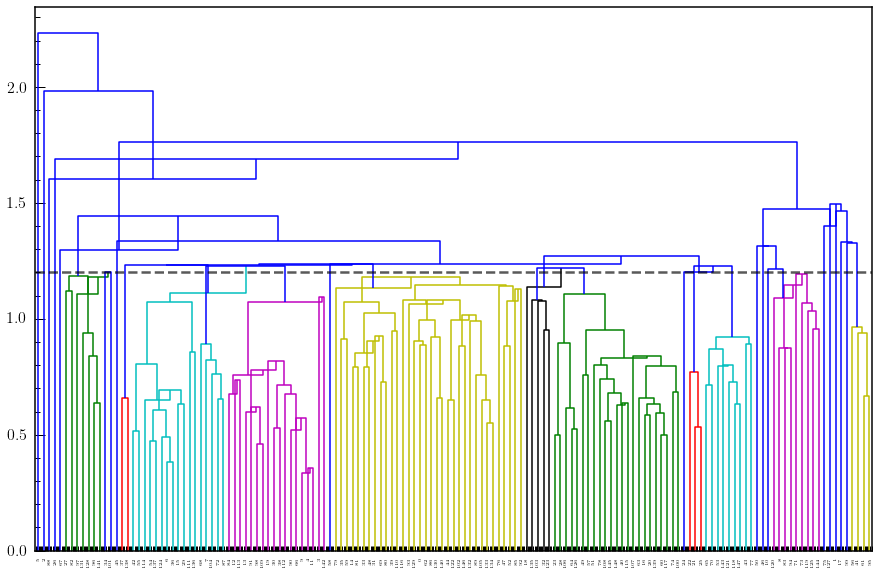

In [7]:
fig, axs = plt.subplots(figsize=(15, 10))
dend = dendrogram(Z, ax = axs, color_threshold=threshold)
axs.plot( axs.get_xlim(),np.ones(2)*threshold, 'k--', linewidth=2.5, alpha=0.65)

In [8]:
# number of "groups" with only one object in it 
print((np.bincount(clusters)==1).sum(), "single groups")
singles = np.where(np.bincount(clusters)==1)[0]

groups = np.where(np.bincount(clusters)>1)[0]

20 single groups


CPU times: user 37.2 s, sys: 588 ms, total: 37.8 s
Wall time: 37.2 s


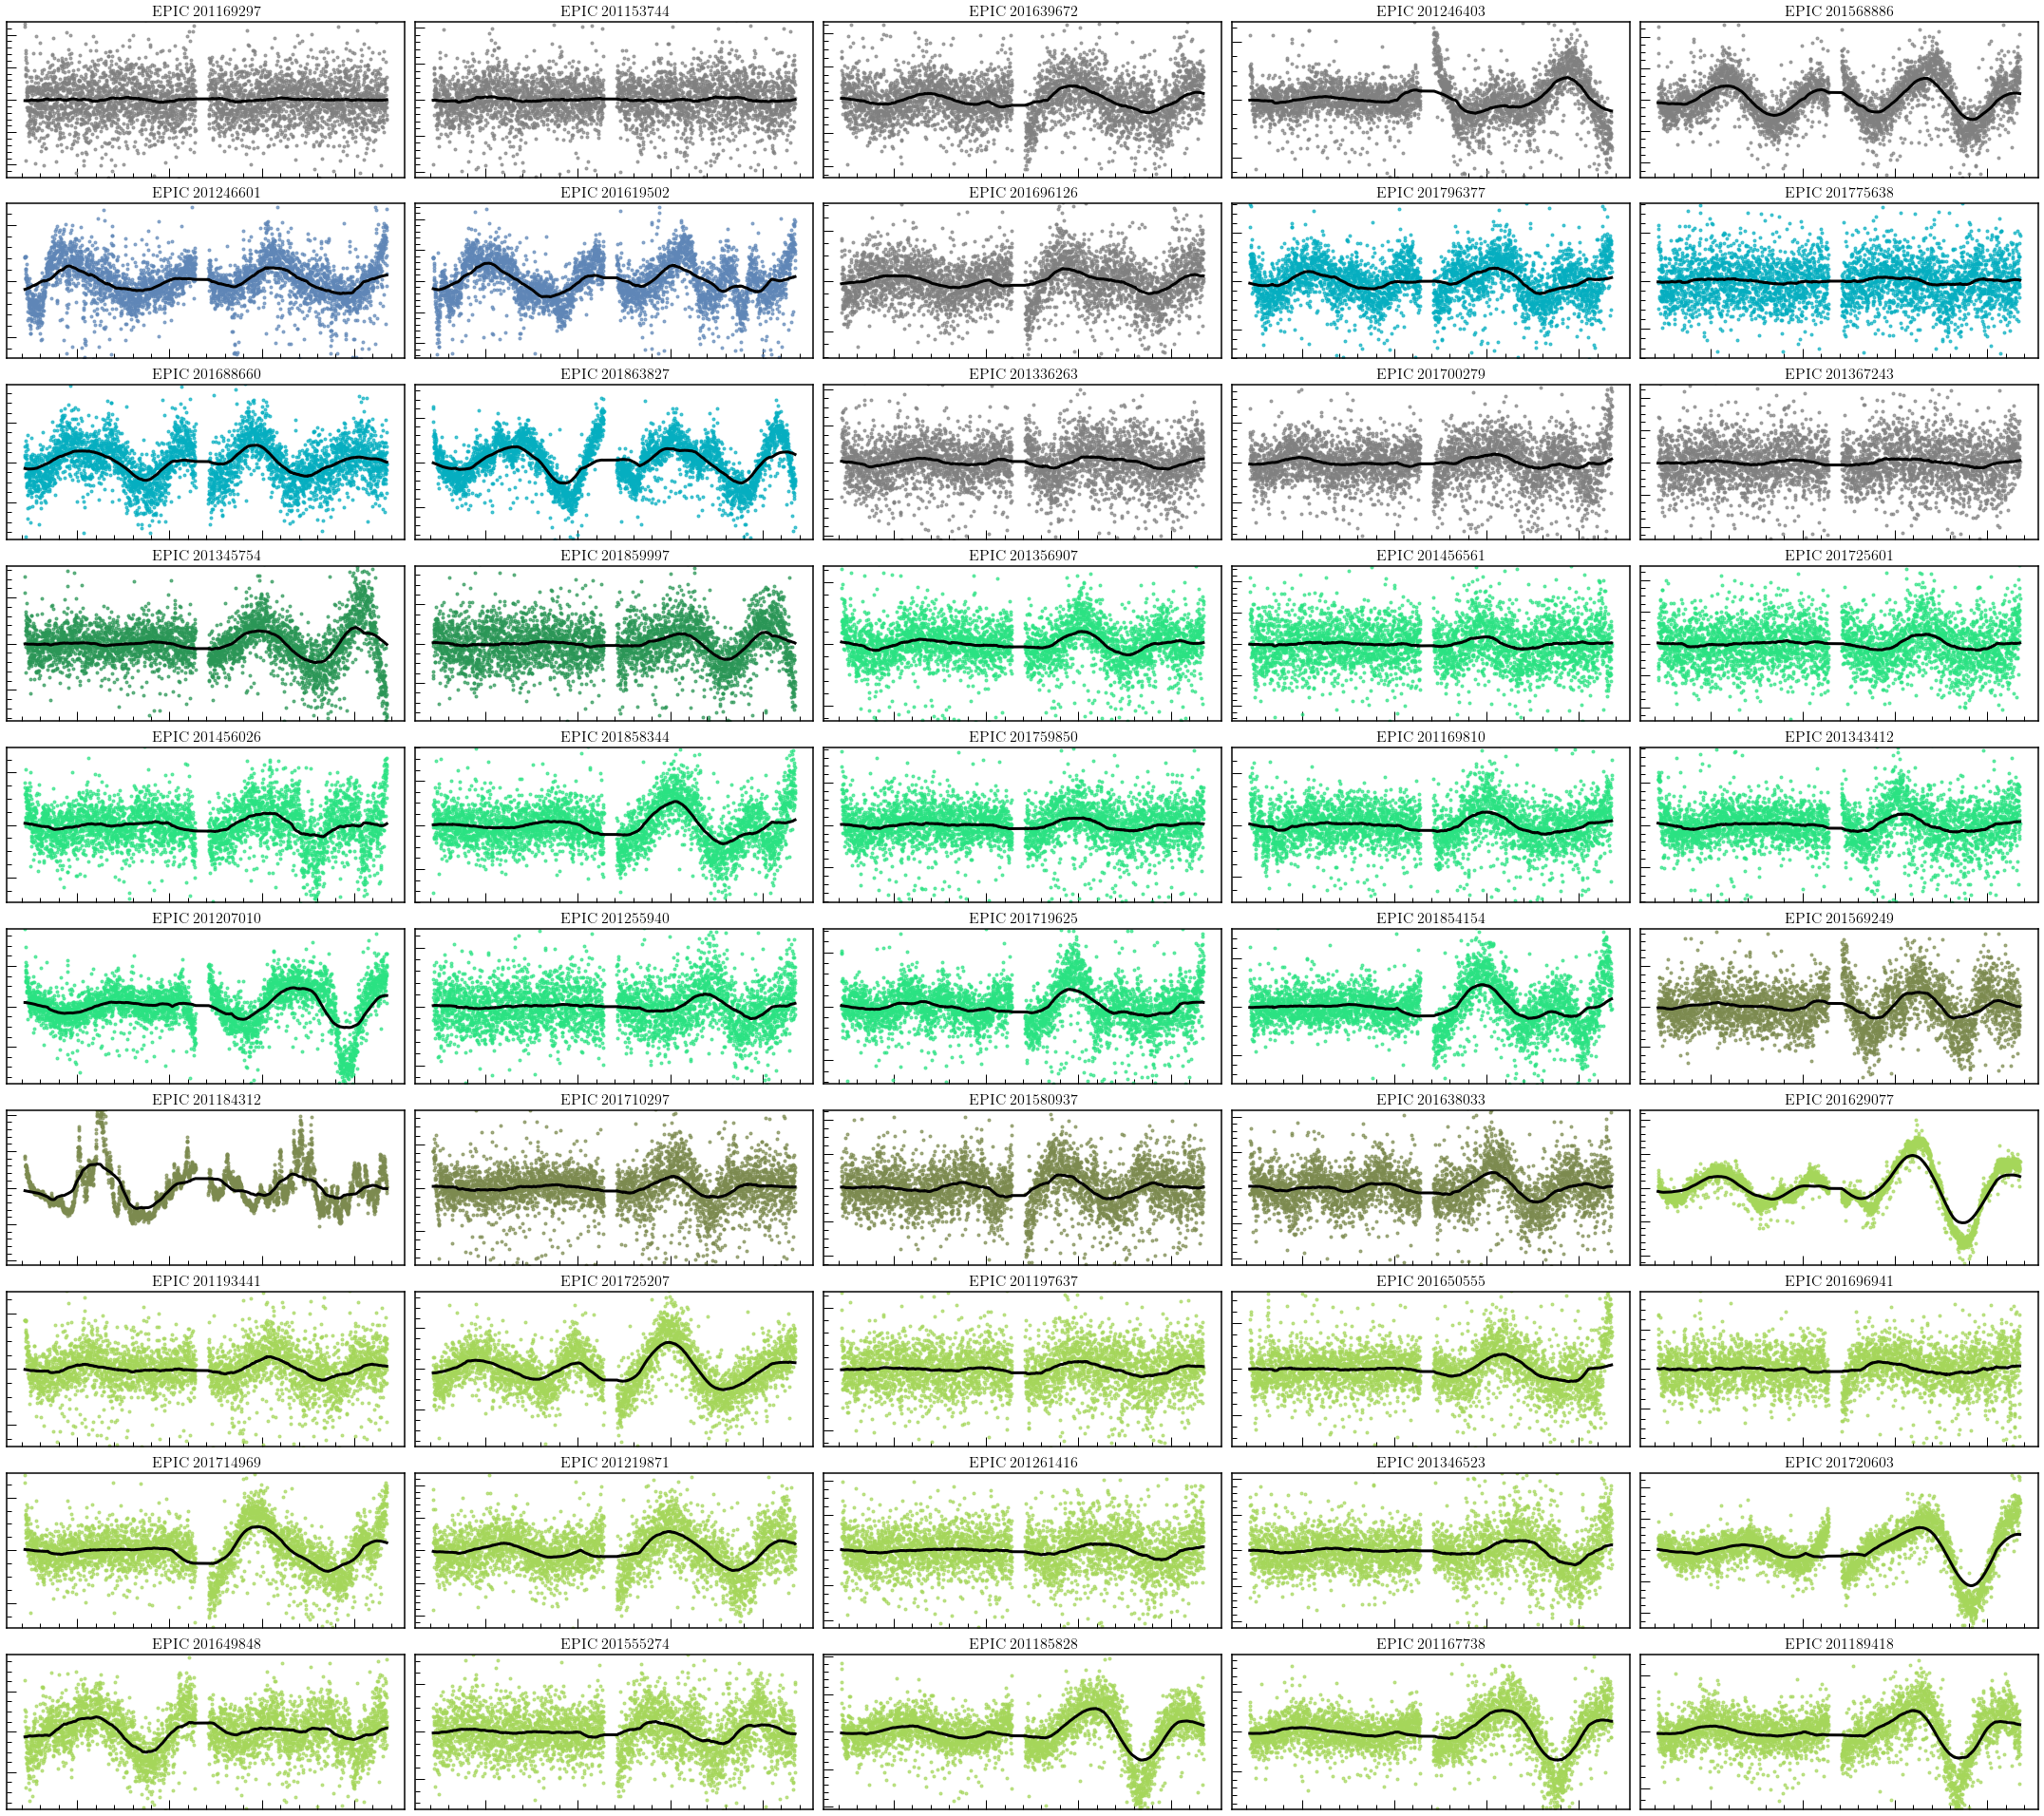

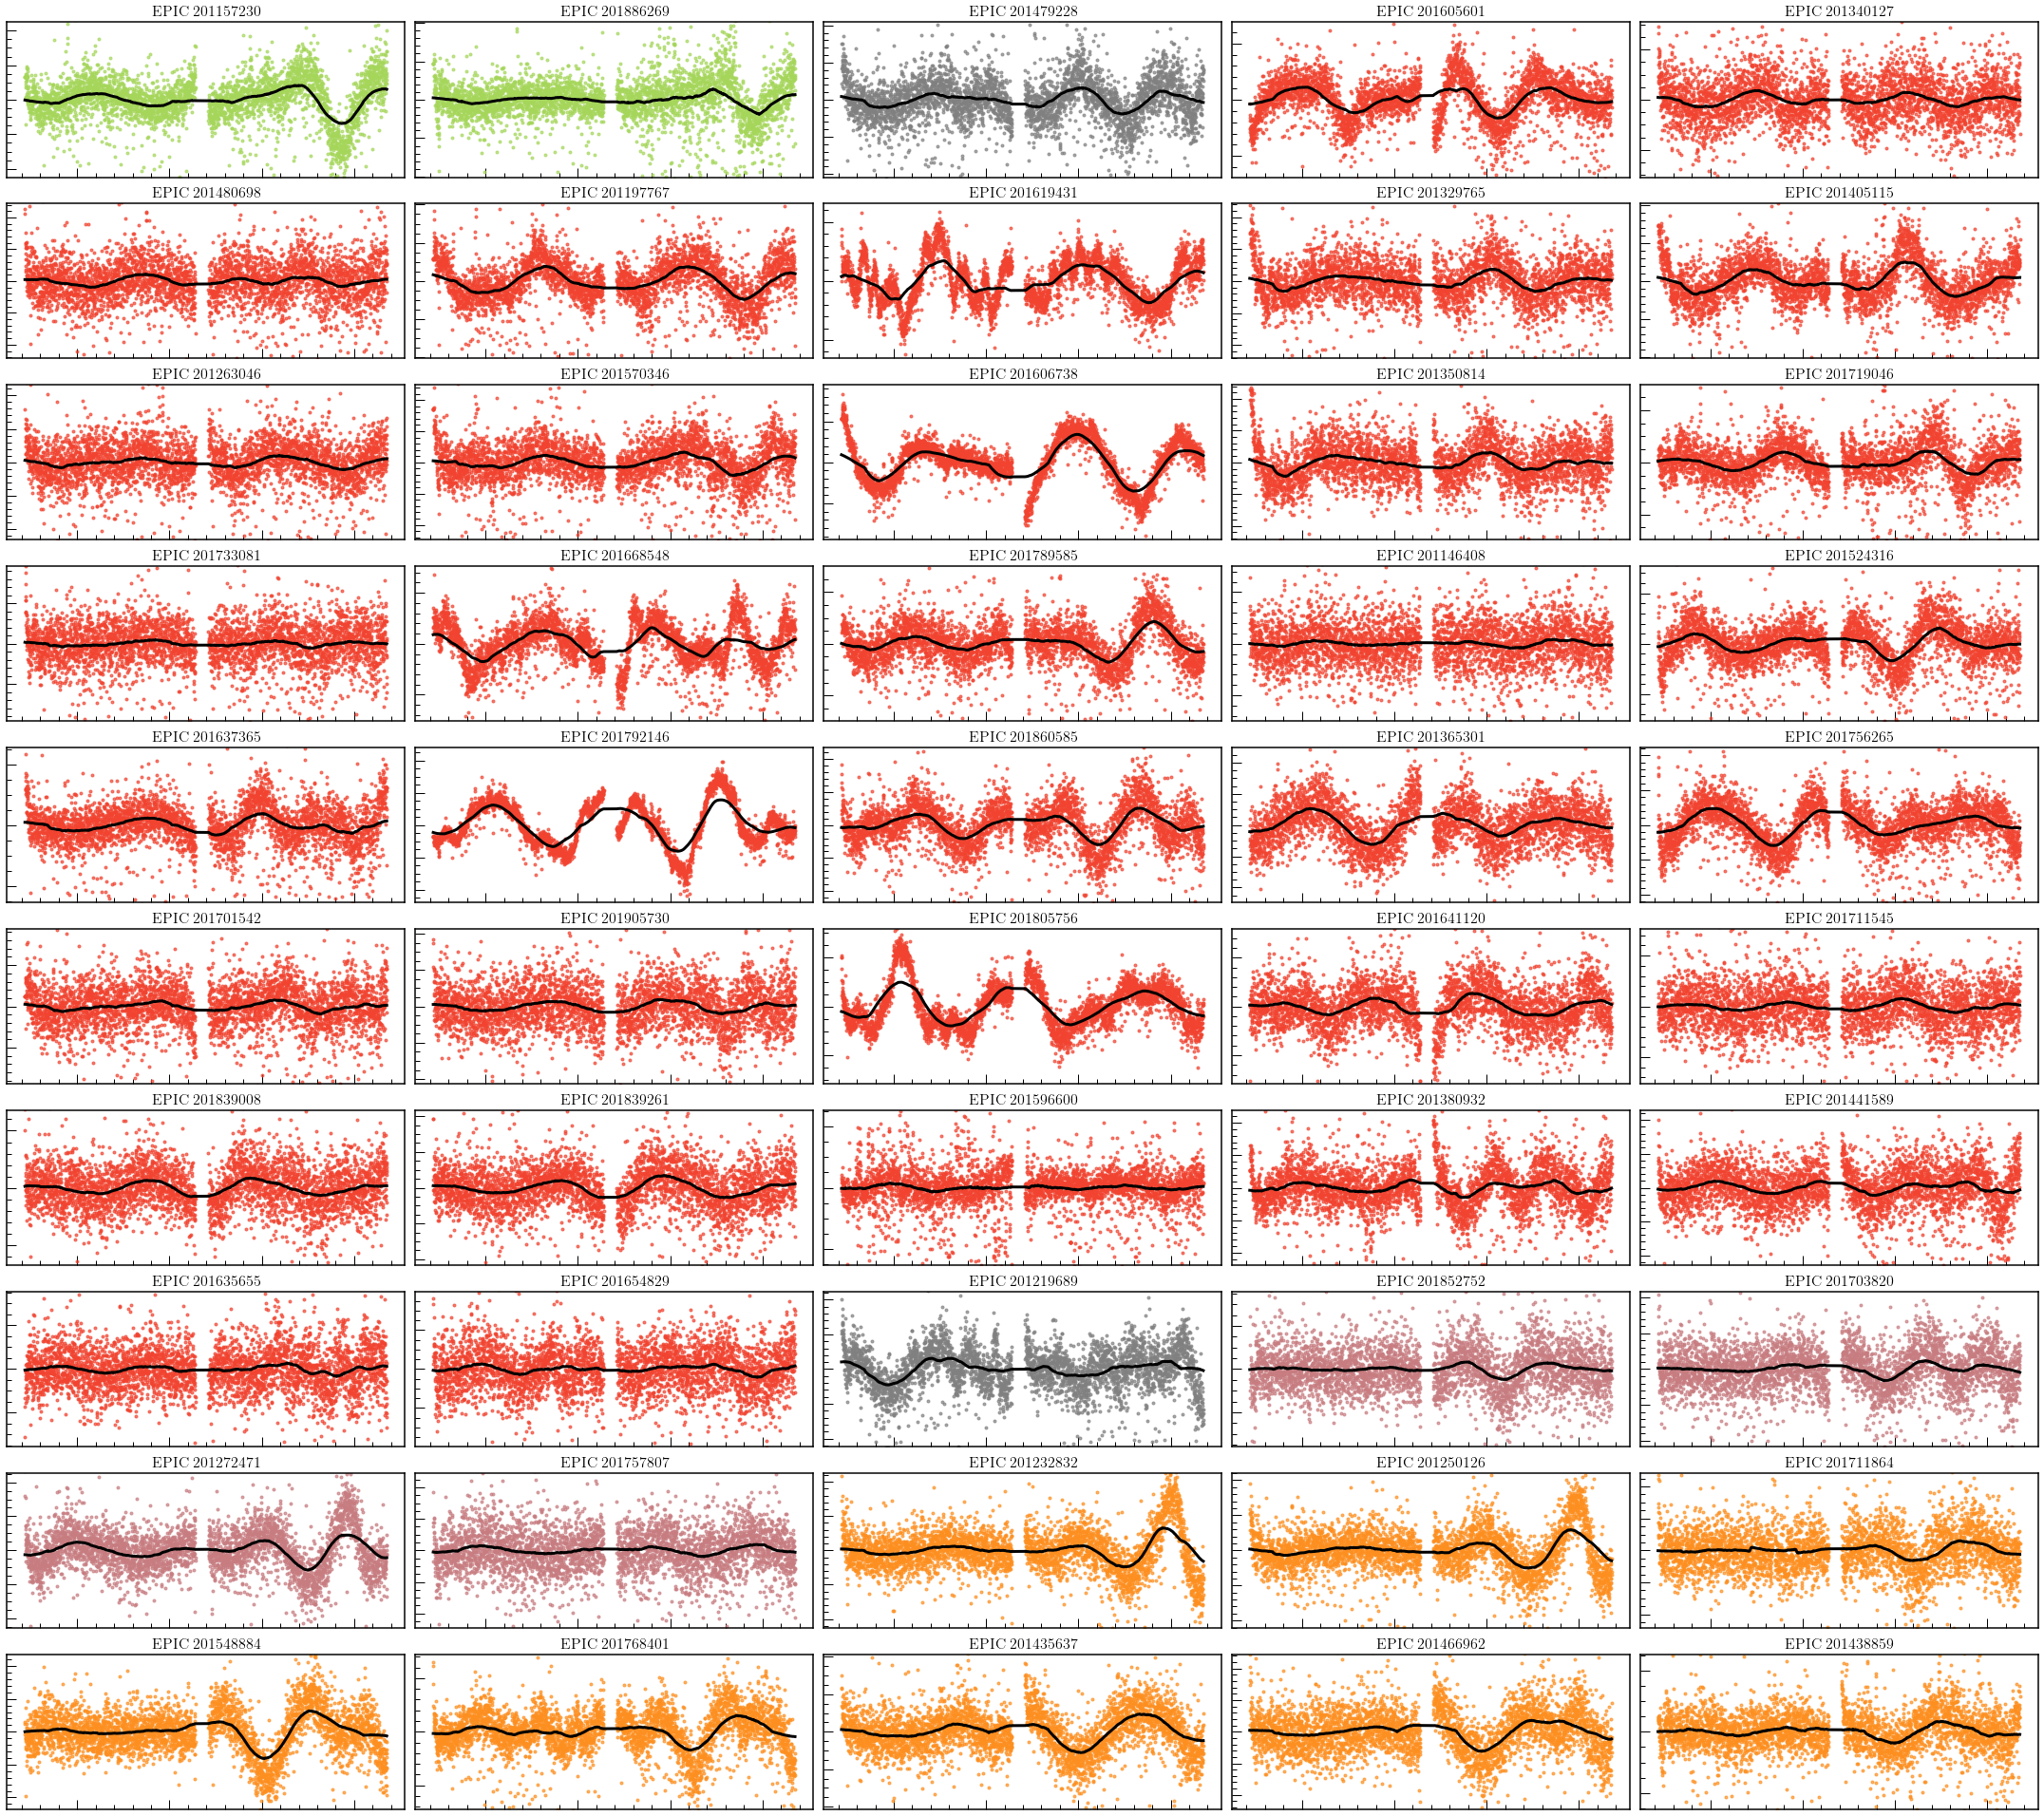

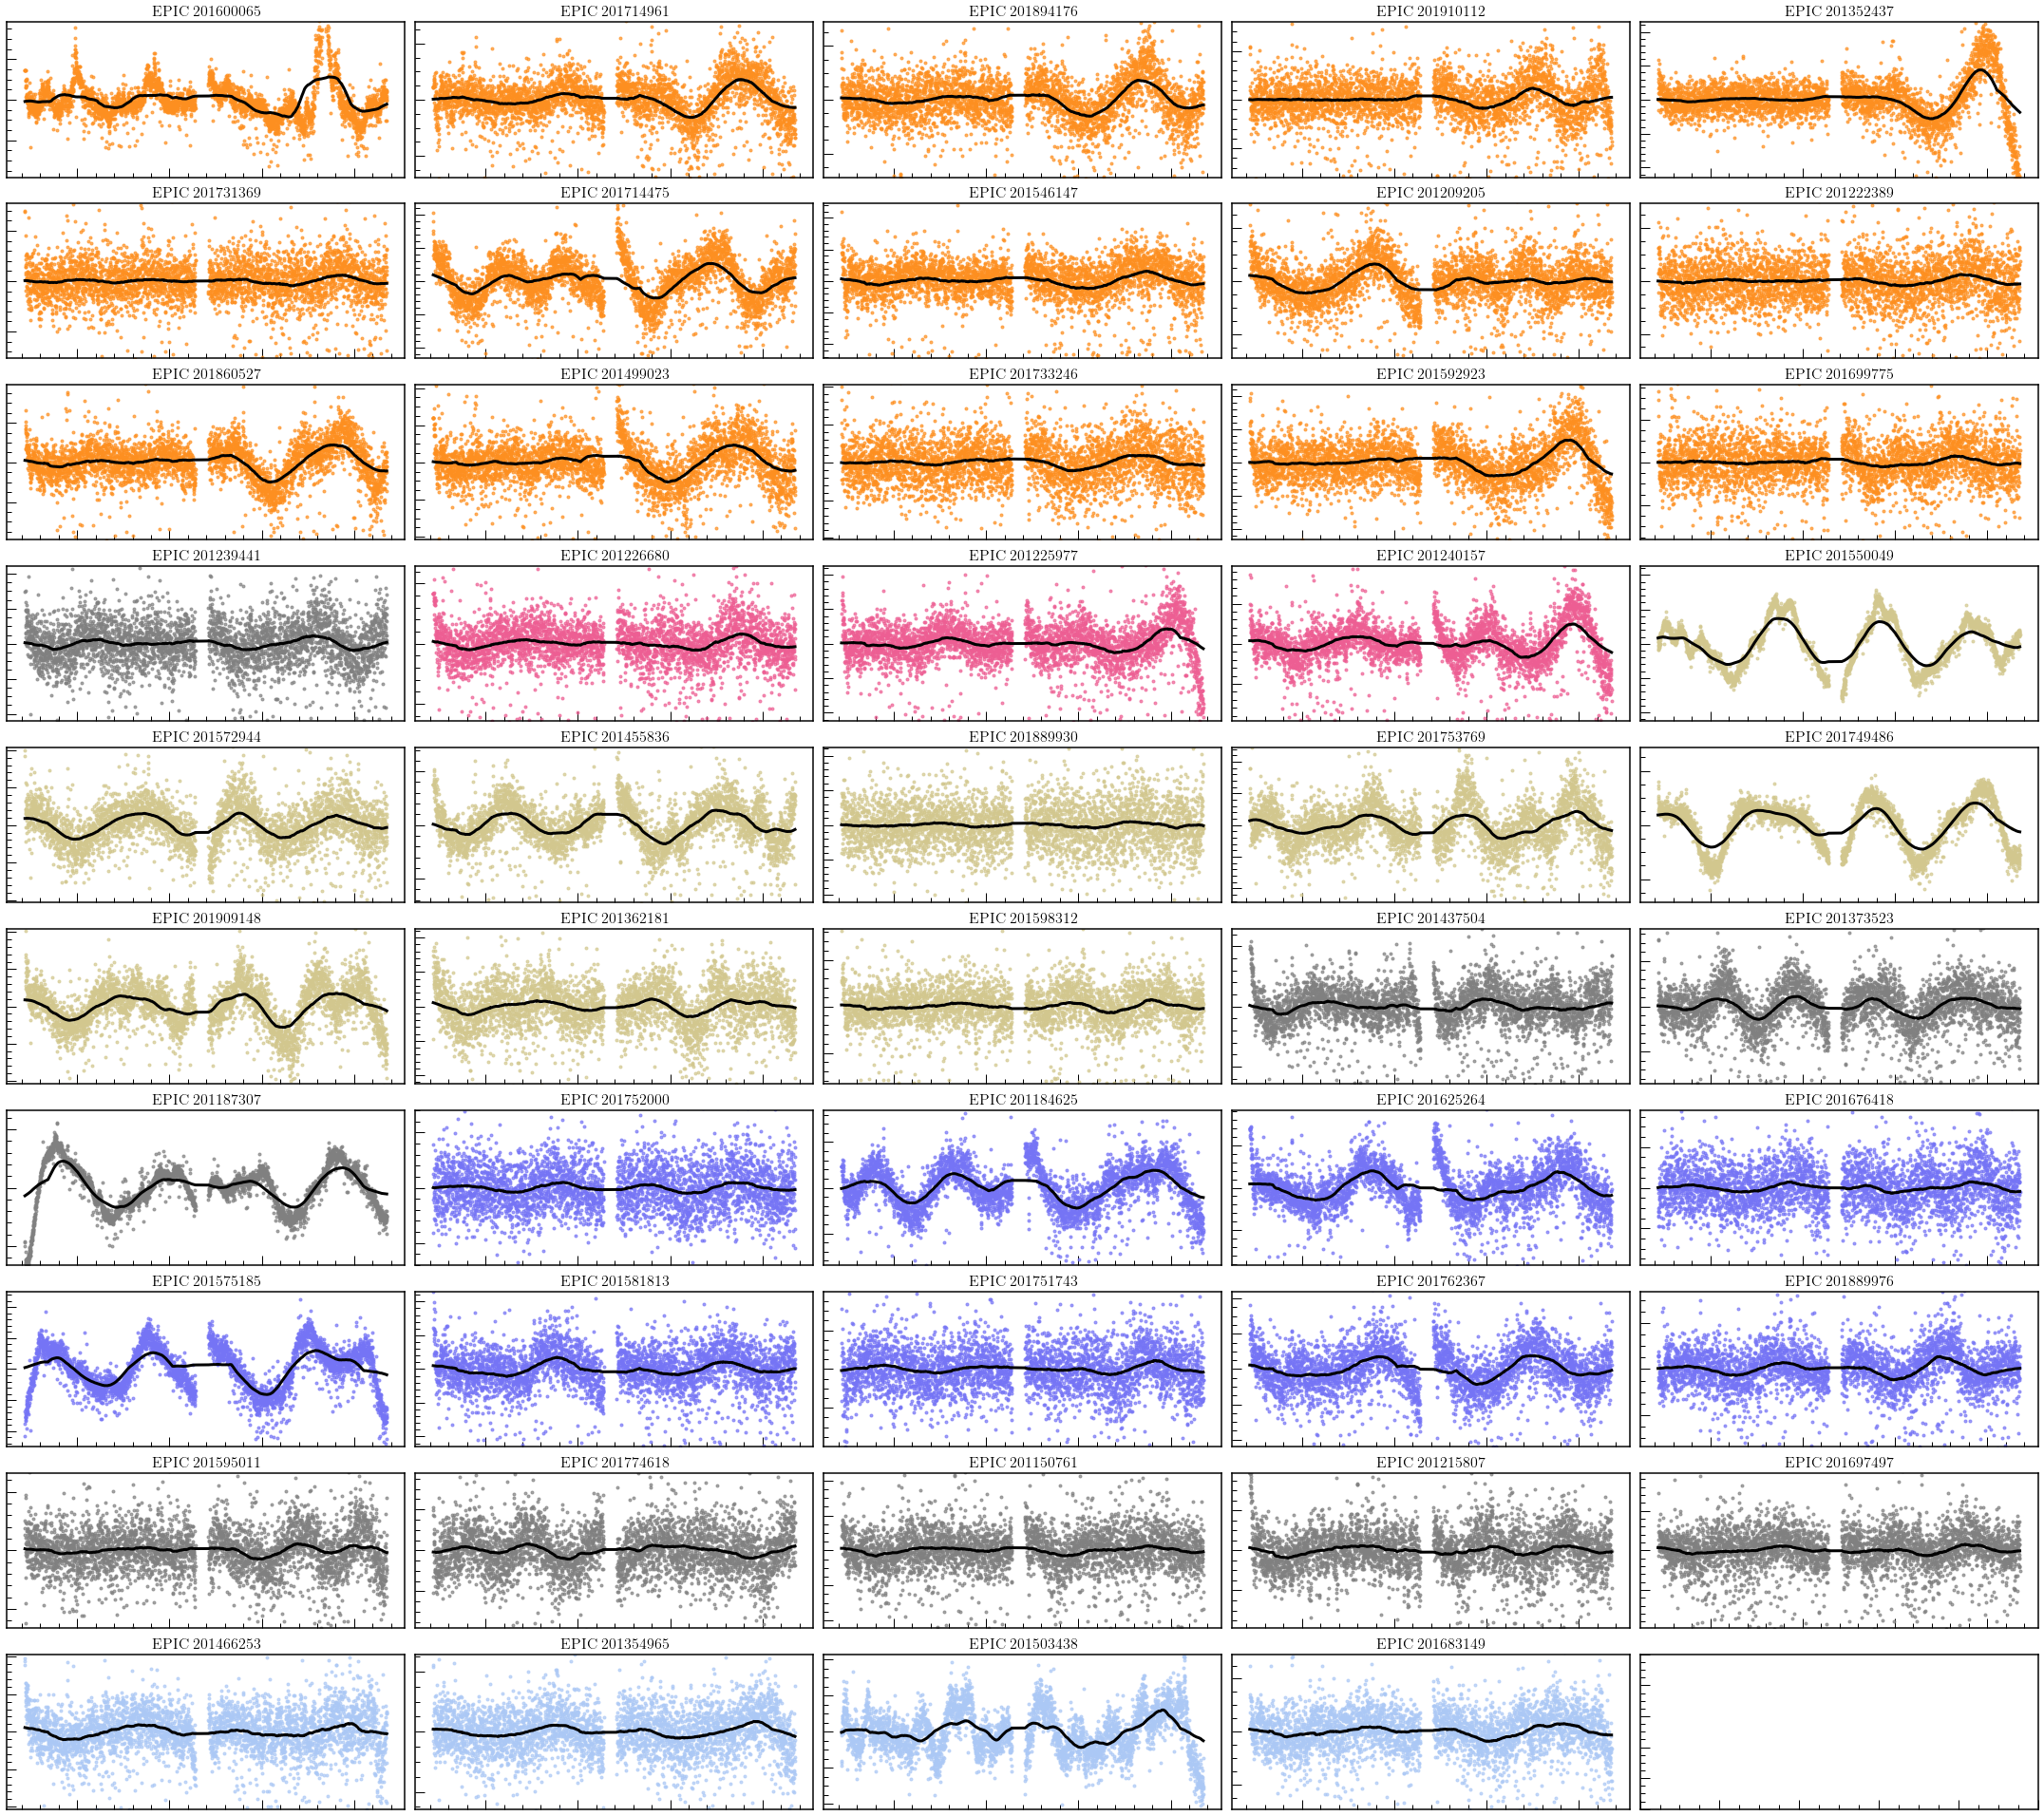

In [9]:
%%time 

# make a loop to not have the figure be giant 
# plotting
numcols = 5
k=0
while k < 150:
    
    #fig, ax = plt.subplots(nrows=int(150/numcols), ncols=numcols, figsize=(30,80))
    fig, ax = plt.subplots(nrows=int(50/numcols), ncols=numcols, figsize=(30,80/3))
    #colors = ['g', 'r', 'c', 'm', 'y', 'b', 'orange', 'pink']

    # generated X number of colors using: http://vrl.cs.brown.edu/color
    colors=['#5f86b7', '#05aec0', '#2a9656', '#2ae282', '#7c8a4f', '#a5d65a', '#f14330', '#c77c80', '#fd8f20', '#ed5e93', '#d2c78e', '#7574f5', '#abc8f5']

    for i, index in enumerate(dend['leaves'][k:k+50]):
        flux = arr[index]
        flux_smooth = arr_smooth[index]

        if np.isin(clusters[index], singles): # color all the single groups grey
            c = 'grey'
        else:
            c = colors[np.where(groups==clusters[index])[0][0]]

        #c = colors[(clusters[index]-1)%len(colors)]

        #  plotting
        ax[i//numcols, i%numcols].plot(full_cad, flux, marker='.', ls =' ', alpha=0.7, c=c, label=clusters[index])
        ax[i//numcols, i%numcols].plot(full_cad, flux_smooth, ls="-", marker='', c="k", linewidth=3, label=clusters[index])
        ax[i//numcols, i%numcols].set_title("EPIC %s"%GO1035["EPIC ID"][index], fontsize=16)
        ax[i//numcols, i%numcols].set_ylim(np.mean(flux)-3.5*np.std(flux), np.mean(flux)+3.5*np.std(flux))
        ax[i//numcols, i%numcols].xaxis.set_ticklabels([])
        ax[i//numcols, i%numcols].yaxis.set_ticklabels([])

    ax[-1, -1].xaxis.set_ticklabels([])
    ax[-1, -1].yaxis.set_ticklabels([])
    plt.tight_layout()
    plt.savefig("submit/Plots/Aranzana_clustering_all_part%s.pdf"%(int(k/50+1)))
    
    
    k+=50

In [10]:
# the cluster numbers sorted by the number of objects in each cluster (highest->lowest)
np.bincount(clusters).argsort()[::-1]

# group #7 has 2 objects

array([10, 13,  9,  7, 16, 20,  8, 12, 24,  2, 15,  6,  1,  5,  4,  3, 11,
       14, 33, 32, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31,  0])

---
Creating plots from individual groups

In [11]:
# make time array to use for plotting (Works for campaign 1)
full_time = (full_cad - np.min(full_cad))/48.0+1977.2622216557138

In [12]:
# 3 groups with 3 objects each
g1 = [201792146, 201805756, 201860585, 201605601, 201756265]
g2 = [201550049, 201749486, 201909148, 201572944, 201753769]
g3 = [201629077, 201167738, 201189418, 201185828, 201157230]

# get the cluster number
cluster1 = clusters[GO1035['EPIC ID']==g1[0]][0]
cluster2 = clusters[GO1035['EPIC ID']==g2[0]][0]
cluster3 = clusters[GO1035['EPIC ID']==g3[0]][0]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


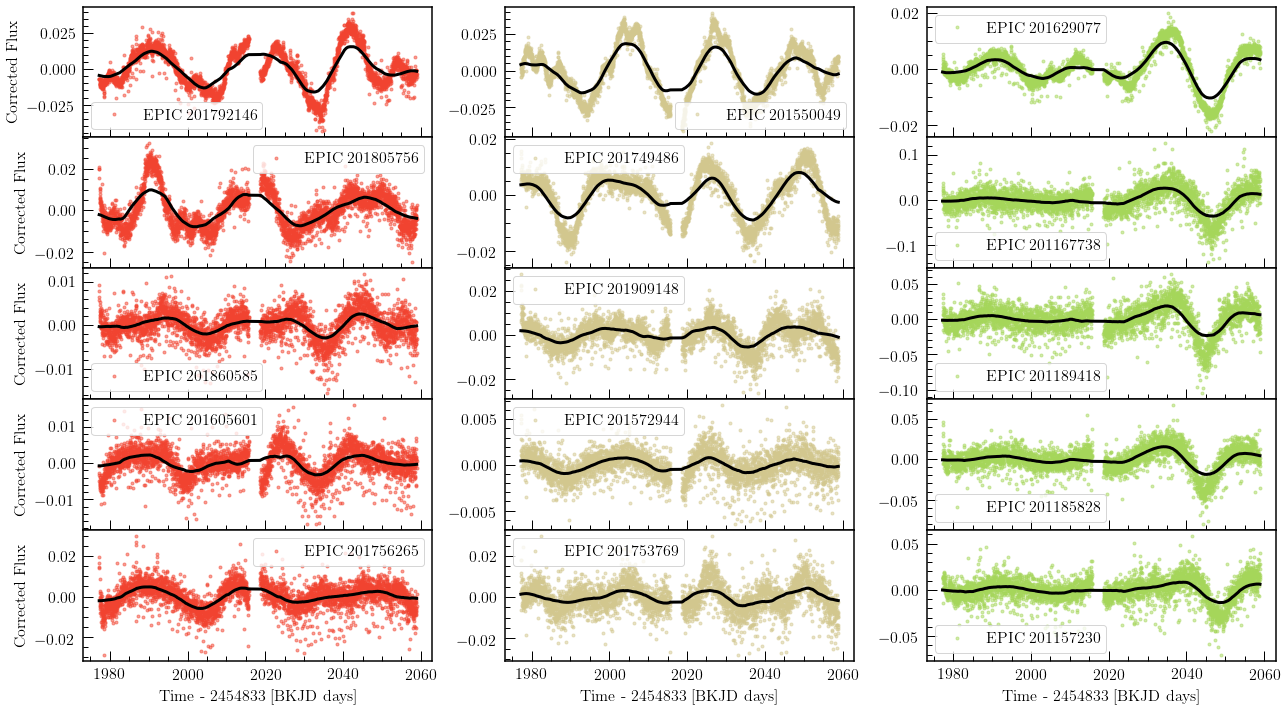

In [13]:
# make the plot we're going to save 

fig, ax = plt.subplots(5, 3, figsize=(18,10), sharex=True, gridspec_kw = {'hspace':0})

# first group
color1 = colors[np.where(groups==cluster1)[0][0]]
for i, epic in enumerate(g1):
    mask = np.array(GO1035['EPIC ID']==epic)
    flux = arr[mask][0]
    flux_smooth = arr_smooth[mask][0]
    ax[i,0].plot(full_time, flux, '.', alpha=0.5,color=color1, label="EPIC %s"%epic)
    ax[i,0].plot(full_time, flux_smooth, c="k", linewidth=3)#, color="#273c75")
    ax[i,0].legend(fontsize=16)
    ax[i,0].set_ylabel("Corrected Flux", fontsize=16)
    
    if i<2:
        ax[i,0].set_xlabel("")
    else:
        ax[i,0].set_xlabel("Time - 2454833 [BKJD days]", fontsize=16)


# second group
color2 = colors[np.where(groups==cluster2)[0][0]]
for i, epic in enumerate(g2):
    mask = np.array(GO1035['EPIC ID']==epic)
    flux = arr[mask][0]
    flux_smooth = arr_smooth[mask][0]
    ax[i,1].plot(full_time, flux, '.', alpha=0.5,color=color2, label="EPIC %s"%epic)
    ax[i,1].plot(full_time, flux_smooth, c="k", linewidth=3)#, color="#273c75")
    ax[i,1].legend(fontsize=16)
    #ax[i,1].set_ylabel("Corrected Flux", fontsize=16)
    
    if i<2:
        ax[i,1].set_xlabel("")
    else:
        ax[i,1].set_xlabel("Time - 2454833 [BKJD days]", fontsize=16)



# third group
color3 = colors[np.where(groups==cluster3)[0][0]]
for i, epic in enumerate(g3):
    mask = np.array(GO1035['EPIC ID']==epic)
    flux = arr[mask][0]
    flux_smooth = arr_smooth[mask][0]
    ax[i,2].plot(full_time, flux, '.', alpha=0.5,color=color3, label="EPIC %s"%epic)
    ax[i,2].plot(full_time, flux_smooth, c="k", linewidth=3)#, color="#273c75")
    ax[i,2].legend(fontsize=16)
    #ax[i,1].set_ylabel("Corrected Flux", fontsize=16)
    
    if i<2:
        ax[i,2].set_xlabel("")
    else:
        ax[i,2].set_xlabel("Time - 2454833 [BKJD days]", fontsize=16)



plt.tight_layout()
plt.savefig("submit/Plots/Aranzana_Clusters_examples.pdf")

TODO: Create Dendrogram labeled by channel number (?, probably)